In [1]:
import pandas as pd
import numpy as np
import feather

from tqdm import tqdm

In [2]:
def evaluation_metric(y_true, y_pred):
    y_pred = y_pred.copy()
    y_pred[y_pred < 1.0] = 1.0
    y_pred = np.round(y_pred)
    scores = (y_pred - y_true) / (y_pred + y_true)
    scores[y_true < 1] = 0.0
    return np.abs(scores).mean()

In [3]:
df_base = feather.read_dataframe('features/base_features.feather')
df_mean_window = feather.read_dataframe('features/window_mean_features.feather')
df_trend_window = feather.read_dataframe('features/window_trend_features.feather')
df_week_trend = feather.read_dataframe('features/weekly_trends_features.feather')

In [4]:
common = (set(df_base.columns) & set(df_mean_window.columns))

In [5]:
for c in common:
    if not (df_base[c].fillna(-1) == df_mean_window[c].fillna(-1)).all():
        print('uwaga')
    if not (df_base[c].fillna(-1) == df_trend_window[c].fillna(-1)).all():
        print('uwaga')
    if not (df_base[c].fillna(-1) == df_week_trend[c].fillna(-1)).all():
        print('uwaga')

In [6]:
df_mean_window = df_mean_window[sorted(set(df_mean_window.columns) - common)]
df_trend_window = df_trend_window[sorted(set(df_trend_window.columns) - common)]
df_week_trend = df_week_trend[sorted(set(df_week_trend.columns) - common)]

In [7]:
df_features = pd.concat([df_base, df_mean_window, df_trend_window, df_week_trend], axis=1)

In [8]:
shops = df_features.shop_id.unique()
shops = sorted(shops)

In [9]:
df_train = df_features[df_features.biweek_id > 1].reset_index(drop=1)
df_val = df_features[df_features.biweek_id == 1].reset_index(drop=1)
df_test = df_features[df_features.biweek_id == 0].reset_index(drop=1)

In [11]:
len(df_train)

525010

In [10]:
df_train = df_train[~df_train.pays_count.isnull()].reset_index(drop=1)
df_val = df_val[~df_val.pays_count.isnull()].reset_index(drop=1)

Remove outliers from training

In [12]:
from sklearn.linear_model import Ridge

def linear_fit(group):
    y = group.pays_count
    not_null = ~y.isnull()

    x = group.days_from_beginning
    x_not_null = x[not_null].values.reshape(-1, 1)
    y = y[not_null].values
    lr = Ridge(alpha=1).fit(x_not_null, y)

    return pd.Series(lr.predict(x.values.reshape(-1, 1)), x.index)

In [13]:
trends = df_train.groupby('shop_id').apply(linear_fit)
trends = trends.reset_index(drop=1)

In [14]:
mae = (df_train.pays_count - trends).abs()

In [15]:
std = pd.groupby(mae, by=df_train.shop_id).std()
std = std[df_train.shop_id].reset_index(drop=1)

In [16]:
outliers = mae > (std * 4)

In [17]:
df_train = df_train[~outliers]

## Some stuff

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    y_pred = y_pred[~np.isnan(y)]
    y = y[~np.isnan(y)]

    y = y[~np.isnan(y_pred)]
    y_pred = y_pred[~np.isnan(y_pred)]

    return np.sqrt(mean_squared_error(y, y_pred))

In [20]:
y_train = df_train.pays_count.values
y_val = df_val.pays_count.values

### Median trend features

In [21]:
trend_groups = [
    ('trend', ['trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_12', 'trend_18']),
    ('trend_dow', ['trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 
                   'trend_dow_12', 'trend_dow_18']),
    ('trend_weekend', ['trend_weekend_3', 'trend_weekend_4', 'trend_weekend_5',
                       'trend_weekend_6', 'trend_weekend_12', 'trend_weekend_18']),
]

In [22]:
for n, g in trend_groups:
    df_train[n + '_median'] = df_train[g].median(axis=1)
    df_val[n + '_median'] = df_val[g].median(axis=1)
    df_train[n + '_std'] = df_train[g].std(axis=1)
    df_val[n + '_std'] = df_val[g].std(axis=1)

## Model

In [23]:
import xgboost as xgb

In [24]:
to_exclude = {
    'shop_id', 
    'day', 'days_from_beginning', 'pays_count', 'week_id', 'biweek_id',
}
features = sorted(set(df_train.columns) - to_exclude)
print(features)

['biweekly_coef', 'biweekly_dow_coef', 'biweekly_dow_trend', 'biweekly_trend', 'biweekly_weekend_coef', 'biweekly_weekend_trend', 'dow', 'dow_mean_12', 'dow_mean_2', 'dow_mean_3', 'dow_mean_4', 'dow_mean_5', 'dow_mean_6', 'dow_std_12', 'dow_std_2', 'dow_std_3', 'dow_std_4', 'dow_std_5', 'dow_std_6', 'is_weekend', 'mean_1', 'mean_12', 'mean_2', 'mean_3', 'mean_4', 'mean_5', 'mean_6', 'ooo_mean_1', 'ooo_mean_2', 'ooo_mean_3', 'ooo_mean_4', 'out_of_operation', 'pays_two_weeks_ago', 'penultimate', 'penultimate_null', 'second_in_biweek', 'std_1', 'std_12', 'std_2', 'std_3', 'std_4', 'std_5', 'std_6', 'trend_12', 'trend_18', 'trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_coef_12', 'trend_coef_18', 'trend_coef_2', 'trend_coef_3', 'trend_coef_4', 'trend_coef_5', 'trend_coef_6', 'trend_dow_12', 'trend_dow_18', 'trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 'trend_dow_coef_12', 'trend_dow_coef_18', 'trend_dow_coef_3', 'trend_dow_coef_4', 'trend_dow_coef_5', 'trend_dow

In [25]:
X_train = df_train[features].values
X_val = df_val[features].values

In [26]:
def eval_metric(preds, dtrain):
    y_true = dtrain.get_label()
    return 'metric', evaluation_metric(y_true, preds)

### Remove outliers

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features, missing=np.nan)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features, missing=np.nan)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [30]:
xgb_pars = {
    'eta': 0.1,
    'gamma': 0,
    'max_depth': 8,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
    'objective': 'reg:linear',
    #'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 42,
    'silent': 1
}

In [31]:
n_estimators = 101

In [34]:
model = xgb.train(xgb_pars, dtrain, num_boost_round=n_estimators, verbose_eval=5, 
                  evals=watchlist, feval=eval_metric)

[0]	train-rmse:157.065	val-rmse:191.296	train-metric:0.786885	val-metric:0.796192
[5]	train-rmse:100.849	val-rmse:128.413	train-metric:0.342167	val-metric:0.345253
[10]	train-rmse:70.2059	val-rmse:94.7267	train-metric:0.194919	val-metric:0.188209
[15]	train-rmse:54.2382	val-rmse:78.5385	train-metric:0.141362	val-metric:0.130511
[20]	train-rmse:46.2621	val-rmse:70.2351	train-metric:0.122447	val-metric:0.111206
[25]	train-rmse:42.4563	val-rmse:65.7147	train-metric:0.115877	val-metric:0.104812
[30]	train-rmse:40.3302	val-rmse:63.3744	train-metric:0.113366	val-metric:0.102761
[35]	train-rmse:39.1937	val-rmse:62.1756	train-metric:0.112432	val-metric:0.101973
[40]	train-rmse:38.1853	val-rmse:61.4659	train-metric:0.111825	val-metric:0.101727
[45]	train-rmse:37.5264	val-rmse:61.0891	train-metric:0.111441	val-metric:0.101659
[50]	train-rmse:36.8908	val-rmse:60.6995	train-metric:0.111161	val-metric:0.101545
[55]	train-rmse:36.7568	val-rmse:60.5382	train-metric:0.111208	val-metric:0.101578
[60]	t

In [31]:
y_pred = model.predict(dval)
evaluation_metric(y_val, y_pred)

0.10134647057043274

In [34]:
rmse(y_val, y_pred)

61.409453554901042

In [35]:
df_val['pred'] = np.round(y_pred)

In [36]:
scores = model.get_score(importance_type='gain')
sorted(scores.items(), key=lambda x: -x[1])

[('trend_weekend_median', 145222486.837381),
 ('trend_dow_median', 49005607.375405386),
 ('dow_std_12', 9143313.235143347),
 ('trend_weekend_coef_18', 2987963.702774195),
 ('trend_dow_18', 2040584.7171428574),
 ('trend_weekend_coef_12', 1998428.5274431817),
 ('trend_overall_coeff', 1472421.6619469032),
 ('trend_weekend_6', 1406218.745385185),
 ('trend_coef_12', 1383894.9188392854),
 ('penultimate', 1224355.6747330208),
 ('biweekly_dow_trend', 1222305.9564407826),
 ('trend_18', 1179010.1477327948),
 ('trend_dow_12', 961219.4574769126),
 ('dow_mean_4', 918018.978817205),
 ('ooo_mean_4', 884228.0235102045),
 ('biweekly_trend', 764738.8691801799),
 ('weekly_coef', 758534.0202702705),
 ('trend_2', 755852.90244164),
 ('dow_mean_12', 744642.8380552642),
 ('trend_weekend_coef_3', 592449.924367347),
 ('trend_coef_3', 573367.4317433333),
 ('trend_overall_weekend', 537665.0567721517),
 ('trend_weekend_18', 532946.1372200769),
 ('biweekly_weekend_coef', 519421.5904111112),
 ('trend_weekend_std', 5

In [37]:
set(features) - scores.keys()

{'is_weekend',
 'mean_12',
 'mean_2',
 'mean_3',
 'mean_4',
 'mean_5',
 'mean_6',
 'out_of_operation',
 'penultimate_null',
 'std_12',
 'std_2',
 'std_3',
 'std_4',
 'std_5',
 'std_6',
 'weekend_mean_12',
 'weekend_mean_2',
 'weekend_mean_3',
 'weekend_mean_4',
 'weekend_mean_5',
 'weekend_mean_6',
 'weekend_std_12',
 'weekend_std_2',
 'weekend_std_3',
 'weekend_std_4',
 'weekend_std_5',
 'weekend_std_6'}

In [38]:
nom = (df_val.pays_count - df_val.pred).abs()
denom = (df_val.pays_count + df_val.pred)
df_val['score'] = nom / denom

In [39]:
df_val.score.hist(bins=51)

In [40]:
val_mean_score = df_val.groupby('shop_id').score.mean()
val_mean_score.sort_values(ascending=False)

shop_id
810     0.868587
1918    0.773590
1556    0.738055
742     0.516086
1548    0.480525
632     0.464393
474     0.459073
1843    0.452030
23      0.446964
1464    0.433443
1747    0.423745
1526    0.411231
459     0.402838
1384    0.390728
1214    0.381862
1629    0.367309
727     0.366093
561     0.345310
352     0.329120
1426    0.324574
1561    0.323810
1875    0.315589
749     0.311623
1510    0.307389
524     0.306853
1218    0.303105
1856    0.303041
1100    0.301268
619     0.290740
1107    0.289983
          ...   
86      0.037611
1489    0.037400
928     0.037294
1584    0.037098
293     0.037091
362     0.037045
395     0.036640
226     0.036381
1285    0.036186
1976    0.036171
1146    0.036073
1624    0.035858
323     0.035766
1392    0.033338
884     0.033268
318     0.033202
565     0.033132
1181    0.033115
82      0.033018
1355    0.033010
909     0.032374
1092    0.032022
820     0.031310
1025    0.030985
1365    0.028665
516     0.028203
1901    0.025850
1874  

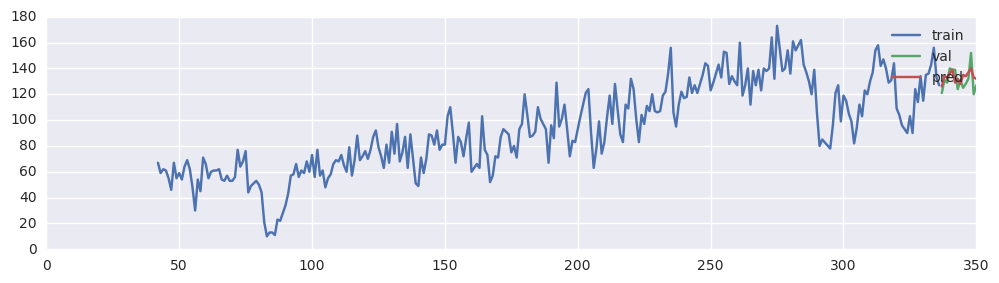

In [44]:
shop_id = 968
df_shop_train = df_train[df_train.shop_id == shop_id]
df_shop_val = df_val[df_val.shop_id == shop_id]

plt.figure(figsize=(12, 3))
plt.plot(df_shop_train.days_from_beginning, df_shop_train.pays_count, label='train')
#plt.plot(df_shop_train.days_from_beginning, df_shop_train., label='median')

plt.plot(df_shop_val.days_from_beginning, df_shop_val.pays_count, label='val')
plt.plot(df_shop_val.days_from_beginning, df_shop_val.pred, label='pred')
plt.legend()
plt.show()

In [76]:
evaluation_metric(y_val, df_val.penultimate)

0.09024919457575448